In [41]:
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [42]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [43]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [44]:
numeric = train.select_dtypes(exclude='object')
categorical = train.select_dtypes(include='object')

In [45]:
num_corr = numeric.corr()
table = num_corr['SalePrice'].sort_values(ascending=False).to_frame()
cm = sns.light_palette("green", as_cmap=True)
tb = table.style.background_gradient(cmap=cm)
tb

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


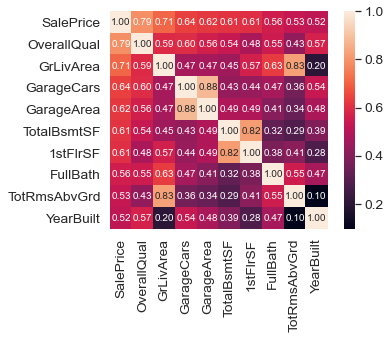

In [46]:
k = 10
cols = train.corr().nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [47]:
ntrain = train.shape[0] # число строк в train
ntest = test.shape[0]   # число строк в test
y = train['SalePrice'].to_frame()
all_data = pd.concat((train,test),sort=False).reset_index(drop = True)
all_data.drop(['SalePrice','Id'], axis = 1, inplace = True)

In [48]:
all_data = all_data.dropna(thresh = len(all_data) * 0.8, axis = 1)

all_data.shape

(2919, 74)

**Заполняем пропуски в данных**

In [49]:
# только категориальные признаки содержащие NaN
NanCat = all_data.loc[:,all_data.isna().any()].select_dtypes(include='object')

In [50]:
# заполним колонки с 1 "NaN" прямым заполнением
fill_cols = ['Electrical', 'SaleType', 'KitchenQual', 'Exterior1st',
             'Exterior2nd', 'Functional', 'Utilities', 'MSZoning']

for col in all_data[fill_cols]:
    all_data[col] = all_data[col].fillna(method='ffill')


In [51]:
#Categorical missing values
NAcols = all_data.columns
for col in NAcols:
    if all_data[col].dtype == "object":
        all_data[col] = all_data[col].fillna("None")

In [52]:
for col in NAcols:
    if all_data[col].dtype != "object":
        all_data[col]= all_data[col].fillna(0)

In [53]:
all_data.isnull().sum().sort_values(ascending=False).head()

SaleCondition    0
YearRemodAdd     0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
dtype: int64

**Преобразуем несколько признаков в более информативные признаки**

In [54]:
all_data['TotalArea'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF'] + all_data['GrLivArea'] +all_data['GarageArea']
all_data['Bathrooms'] = all_data['FullBath'] + all_data['HalfBath']*0.5 
all_data['Year average']= (all_data['YearRemodAdd']+all_data['YearBuilt'])/2

**Переводим категориальные признаки**

In [55]:
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)

In [56]:
# сделаем колонку Есть/Нет подвал
all_data['HasBsmt'] = pd.Series(len(all_data['TotalBsmtSF']), index=all_data.index)
all_data['HasBsmt'] = 0 
all_data.loc[all_data['TotalBsmtSF']>0,'HasBsmt'] = 1

all_data = pd.get_dummies(all_data)

In [57]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [58]:
train['TotalBsmtSF']

0        856.0
1       1262.0
2        920.0
3        756.0
4       1145.0
         ...  
1455     953.0
1456    1542.0
1457    1152.0
1458    1078.0
1459    1256.0
Name: TotalBsmtSF, Length: 1460, dtype: float64

**Анализ выбросов**

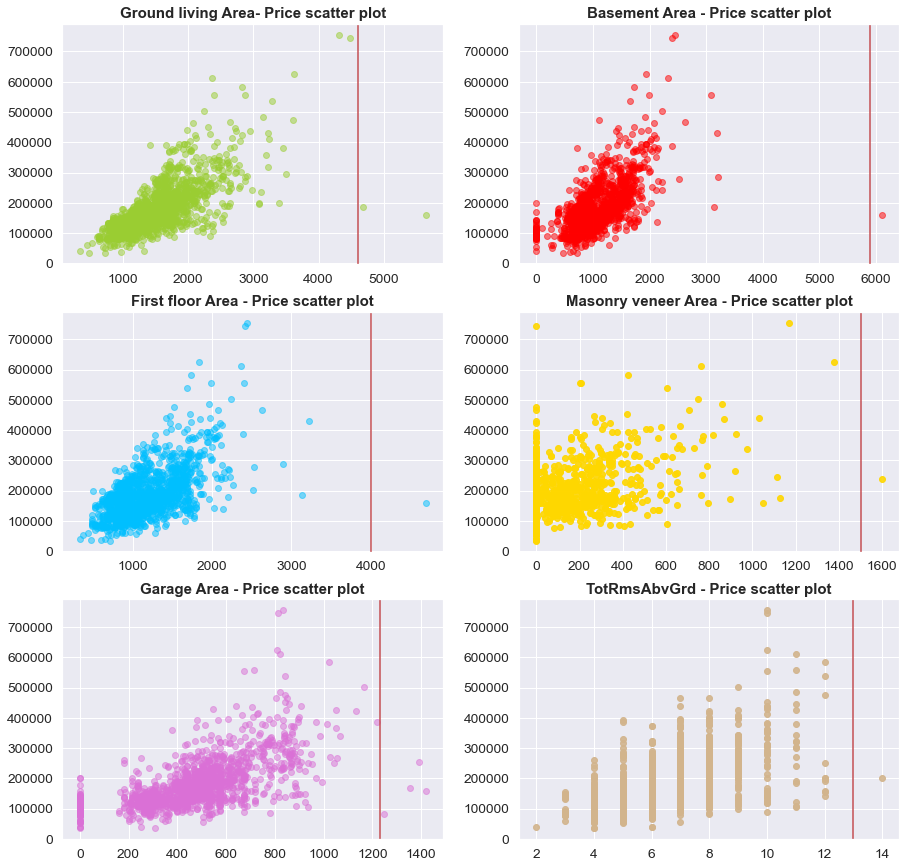

In [59]:
fig = plt.figure(figsize=(15,15))
ax1 = plt.subplot2grid((3,2),(0,0))
plt.scatter(x = train['GrLivArea'], y = y, color=('yellowgreen'), alpha=0.5)
plt.axvline(x=4600, color='r', linestyle='-')
plt.title('Ground living Area- Price scatter plot', fontsize=15, weight='bold' )

ax1 = plt.subplot2grid((3,2),(0,1))
plt.scatter(x = train['TotalBsmtSF'], y = y, color=('red'),alpha=0.5)
plt.axvline(x=5900, color='r', linestyle='-')
plt.title('Basement Area - Price scatter plot', fontsize=15, weight='bold' )

ax1 = plt.subplot2grid((3,2),(1,0))
plt.scatter(x = train['1stFlrSF'], y = y, color=('deepskyblue'),alpha=0.5)
plt.axvline(x=4000, color='r', linestyle='-')
plt.title('First floor Area - Price scatter plot', fontsize=15, weight='bold' )

ax1 = plt.subplot2grid((3,2),(1,1))
plt.scatter(x = train['MasVnrArea'], y = y, color=('gold'),alpha=0.9)
plt.axvline(x=1500, color='r', linestyle='-')
plt.title('Masonry veneer Area - Price scatter plot', fontsize=15, weight='bold' )

ax1 = plt.subplot2grid((3,2),(2,0))
plt.scatter(x = train['GarageArea'], y = y, color=('orchid'),alpha=0.5)
plt.axvline(x=1230, color='r', linestyle='-')
plt.title('Garage Area - Price scatter plot', fontsize=15, weight='bold' )

ax1 = plt.subplot2grid((3,2),(2,1))
plt.scatter(x = train['TotRmsAbvGrd'], y = y, color=('tan'),alpha=0.9)
plt.axvline(x=13, color='r', linestyle='-')
plt.title('TotRmsAbvGrd - Price scatter plot', fontsize=15, weight='bold' )
plt.show()

**Посмотрим на эти выбросы**

In [60]:
train['GrLivArea'].sort_values(ascending=False).head(2)

1298    5642
523     4676
Name: GrLivArea, dtype: int64

In [61]:
train['TotalBsmtSF'].sort_values(ascending=False).head(1)

1298    6110.0
Name: TotalBsmtSF, dtype: float64

In [62]:
train['MasVnrArea'].sort_values(ascending=False).head(1)

297    1600.0
Name: MasVnrArea, dtype: float64

In [63]:
train['1stFlrSF'].sort_values(ascending=False).head(1)

1298    4692
Name: 1stFlrSF, dtype: int64

In [64]:
train['GarageArea'].sort_values(ascending=False).head(4)

1298    1418.0
581     1390.0
1190    1356.0
1061    1248.0
Name: GarageArea, dtype: float64

In [65]:
train['TotRmsAbvGrd'].sort_values(ascending=False).head(1)

635    14
Name: TotRmsAbvGrd, dtype: int64

In [66]:
train = train[(train['GrLivArea'] < 4600) & (train['MasVnrArea'] < 1500)]

pos = [1298,523, 297]
y.drop(y.index[pos], inplace=True)

In [67]:
train.shape

(1457, 302)

**Разделяем выборку**

In [68]:
from sklearn.model_selection import train_test_split
'''X = train.drop(['SalePrice'],axis='columns')'''
X = train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3)


**Стандартизируем данные**

In [69]:
from sklearn.preprocessing import RobustScaler
ss = RobustScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)
y_train = np.array(y_train)

predict_data_scaled = ss.transform(test)

**Строим модель случайных лесов для отбора признаков**

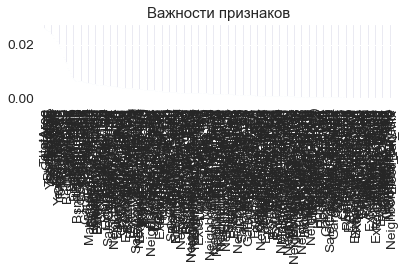

In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
rfc = RandomForestClassifier()
rfc.fit(X_train_scaled, y_train)

feat_labels = all_data.columns
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]

plt.title('Важности признаков')
plt.bar(range(X_train_scaled.shape[1]), importances[indices], color = 'lightblue', align = 'center')
plt.xticks(range(X_train_scaled.shape[1]), feat_labels[indices], rotation = 90)
plt.xlim([-1,X_train_scaled.shape[1]])
plt.tight_layout()
plt.show()


In [71]:
indices

array([  1,  34,  14,  11,   9,  10,  36,  25,   0,  23,   4,  33,   7,
         5,  27,  26,  21,   6,  12,   2,  19,   3,  22,  35,  15, 285,
        28,   8,  61, 211, 282,  75,  64,  24, 283,  30, 265, 284,  18,
       180, 128, 263, 219,  71, 257, 181, 215, 176, 247, 233, 286, 200,
        43, 208, 160, 137, 300, 266, 237, 248, 235,  84, 135, 171, 213,
        17, 131, 106, 261, 193, 185, 169,  57, 214, 207, 156, 161, 295,
       202, 186, 296, 154,  91, 191, 177, 210, 226, 209,  48,  32,  68,
       194, 189,  86, 182,  58, 218,  16,  72, 121, 173, 125, 192, 126,
       272,  29, 204, 255,  47, 105, 301, 259, 216, 245,  87, 178, 281,
       198, 244,  98, 157, 225, 240, 223,  73,  77,  66,  99,  96, 102,
       153,  95, 293, 287, 168,  65,  62,  51,  55,  38,  44, 278, 234,
        76,  93, 133, 279, 100, 252, 251,  94, 203, 151,  85,  90, 238,
       239, 124,  82,  13, 221,  67, 162, 159, 166, 199,  20, 104, 101,
        49, 110, 268, 299,  52, 132, 246, 175, 258, 274, 183, 28

In [75]:
from sklearn.linear_model import ElasticNetCV


alphas = [10,1,0.1,0.01,0.001,0.002,0.003,0.004,0.005,0.00054255]
l1ratio = [0.1, 0.3,0.5, 0.9, 0.95, 0.99, 1]
 
regr = ElasticNetCV(cv = 5,alphas = alphas , l1_ratio = l1ratio , max_iter = 1e7)
regr.fit(X_train_scaled,y_train)
regr.score(X_test_scaled,y_test)

0.9106089594471032

In [37]:
from sklearn.model_selection import GridSearchCV
parametersGrid = {"max_iter": [1, 5, 10],
                      "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                      "l1_ratio": np.arange(0.0, 1.0, 0.1)}
grid = GridSearchCV(regr, parametersGrid, scoring='neg_mean_squared_error', cv=10)
grid.fit(X_train_scaled, y_train)

grid.best_params_

{'alpha': 0.1, 'l1_ratio': 0.8, 'max_iter': 10}

In [76]:
predicts = regr.predict(predict_data_scaled)

df = pd.DataFrame()
df['Id'] = range(1461,2920)
df['SalePrice'] = predicts
df.to_csv('predictions.csv',index = False)